In [2]:
import geopandas as gpd

import pandas as pd
import json
from shapely.geometry import shape

import rasterio.mask
import matplotlib.pyplot as plt

import rasterio as rio

from rasterio import features

import numpy as np

import ast

maryland high school attendance zones from spatialucr quilt

In [2]:
md_sabs13_high = gpd.read_parquet("s3://spatial-ucr/nces/sabs/sabs_1314.parquet", filters=[('stAbbrev', '==', 'MD'), ('sLevel', '==', 3)] )

In [171]:
md_sabs13_high.crs

<Projected CRS: ESRI:102039>
Name: USA_Contiguous_Albers_Equal_Area_Conic_USGS_version
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [3]:
md_sabs13_high = md_sabs13_high.to_crs(4326)

<AxesSubplot:>

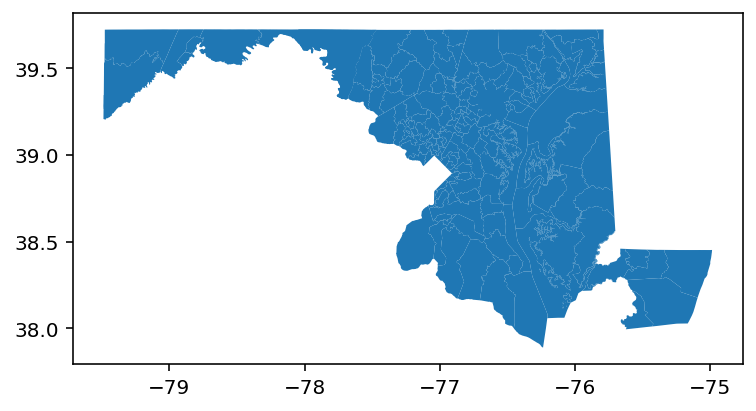

In [174]:
md_sabs13_high.plot()

In [11]:
raster = rio.open('/Users/knaaptime/Downloads/NLCD_Land_Cover_L48_20190424_full_zip/nlcd_2016.tif')

In [12]:
raster_crs = raster.crs.data

In [4]:
cop_path= '/Users/knaaptime/Downloads/W080N40_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif'

In [12]:
nlcd_path = '/Users/knaaptime/Downloads/NLCD_Land_Cover_L48_20190424_full_zip/nlcd_2016.tif'

reproject the vector into the raster's crs

In [14]:
md_sabs13_high =  md_sabs13_high.to_crs(raster.crs.data)

get the geojson representation of the AoI boundary for rasterio

In [16]:
f = [md_sabs13_high.explode().unary_union.__geo_interface__]

open the large raster file and clip the area of interest from the geodataframe. then convert regions of same pixel values into polygons
**this is fairly expensive**

I still need to figure out out how to mask by multiple values, which would presumably cut down on the shape conversion dramatically

In [175]:
with rio.open(nlcd_path) as src:  #read nationwide file
    out_image, out_transform = rio.mask.mask(src, f, nodata=255, crop=True)  # clip to AoI using a vector layer
    mask = np.isin(out_image, [21,22,23,24])  # only include developed pixels
    shapes = list(features.shapes(out_image,mask=mask, transform=out_transform))  # convert regions to polygons

In [176]:
res = list(zip(*shapes))

In [177]:
#res

In [178]:
geoms = pd.Series(res[0], name='geometry').apply(str)

In [179]:
vals = pd.Series(res[1], name='value')

In [180]:
def parse_geom(geom_str):
    return shape(ast.literal_eval(geom_str))

turn the rasterio features into shapely polygons, and into a geodataframe. **this one is very expensive**

In [181]:
geo =  geoms.apply(parse_geom)
gdf = gpd.GeoDataFrame(vals, geometry=geo)

In [185]:
gdf.crs = raster_crs

In [157]:
gdf.crs = 'ESRI:102008'

In [70]:
#gdf = gdf.to_crs(2248)

In [86]:
#gdf['value'] = vals

In [182]:
gdf.head()

,value,geometry
0,21.0,"POLYGON ((1703955.000 2037735.000, 1703955.000..."
1,21.0,"POLYGON ((1703385.000 2037615.000, 1703385.000..."
2,21.0,"POLYGON ((1703865.000 2037585.000, 1703865.000..."
3,22.0,"POLYGON ((1703895.000 2037585.000, 1703895.000..."
4,21.0,"POLYGON ((1703115.000 2037555.000, 1703115.000..."


In [183]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 719419 entries, 0 to 719418
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   value     719419 non-null  float64 
 1   geometry  719419 non-null  geometry
dtypes: float64(1), geometry(1)
memory usage: 11.0 MB


In [88]:
developed = gdf[gdf['value'].isin([21,22,23,24])]

In [89]:
developed.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 719419 entries, 4 to 1524783
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  719419 non-null  geometry
 1   value     719419 non-null  float64 
dtypes: float64(1), geometry(1)
memory usage: 16.5 MB


In [97]:
developed=developed.to_crs(2248)

<AxesSubplot:>

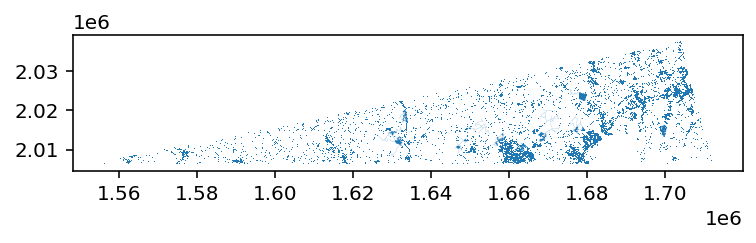

In [184]:
gdf.head(50000).plot()

In [186]:
gdf_md = gdf.to_crs(2248)

<AxesSubplot:>

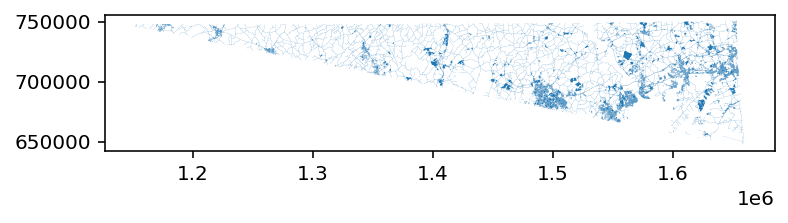

In [187]:
gdf_md.head(50000).plot()

In [90]:
import matplotlib.pyplot as plt

In [188]:
md_sabs13_high = md_sabs13_high.to_crs(2248)

<AxesSubplot:>

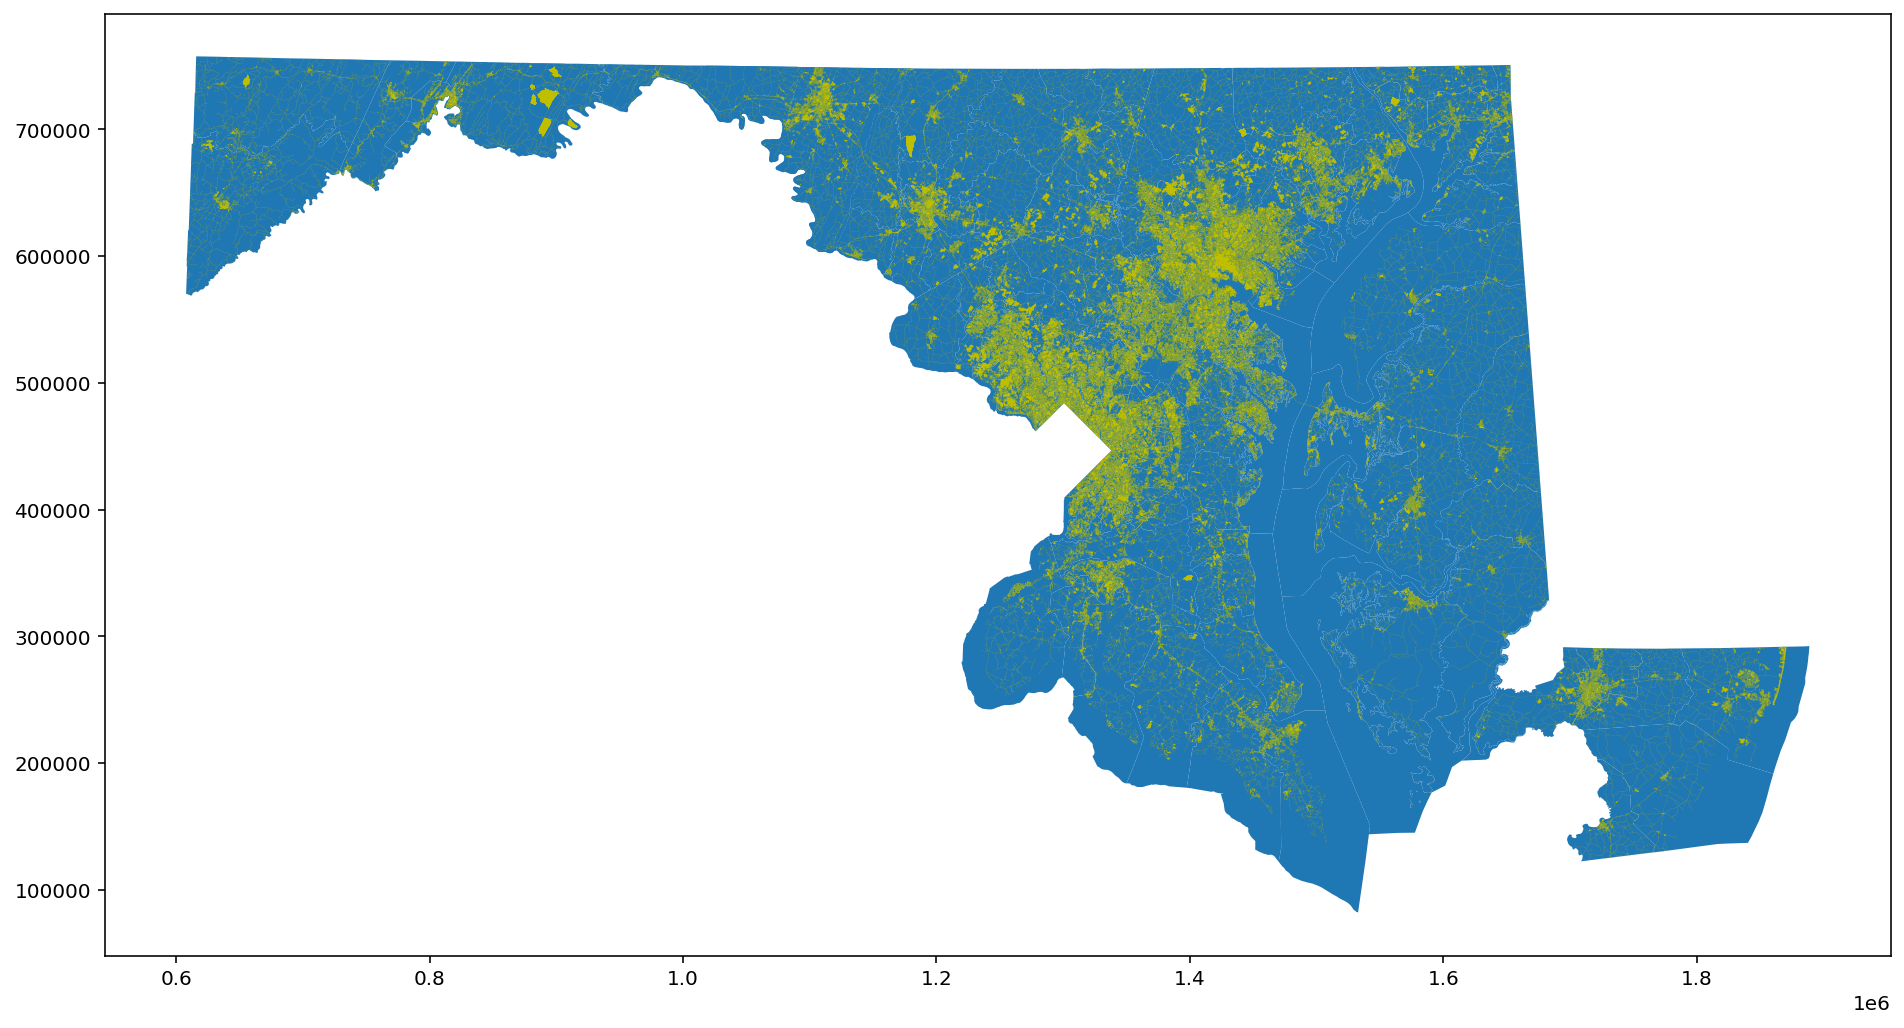

In [195]:
fig, ax = plt.subplots(figsize=(16,16))
md_sabs13_high.plot(ax=ax)
gdf_md.plot(ax=ax,facecolor='y')

<AxesSubplot:>

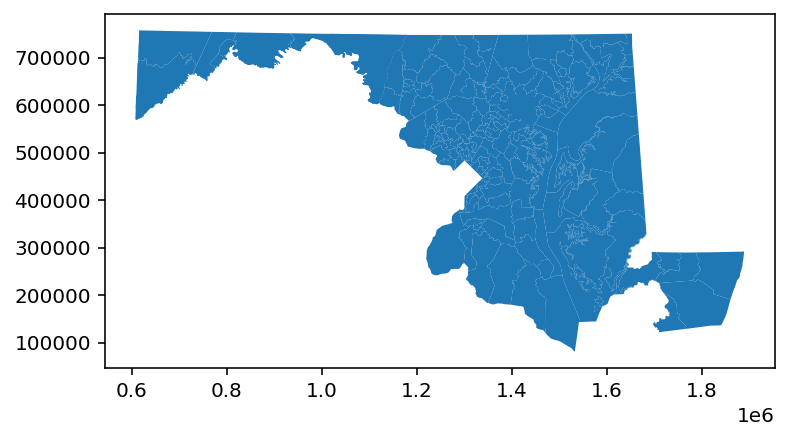

In [166]:
md_sabs13_high.plot()

In [14]:
from tobler.util import extract_raster_features

In [197]:
d = extract_raster_features(md_sabs13_high, cop_path, pixel_types=[50])

/Users/knaaptime/anaconda3/envs/geosnap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

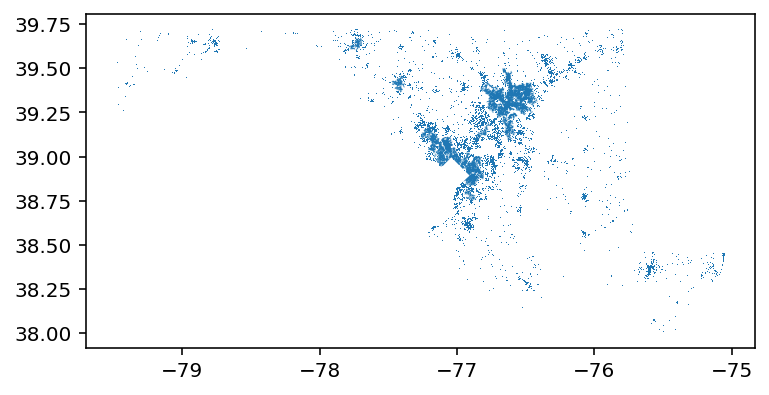

In [200]:
d.plot()

In [201]:
nl = extract_raster_features(md_sabs13_high, nlcd_path, pixel_types=[21,22,23,24])

In [205]:
nl = nl.to_crs(4326)

<AxesSubplot:>

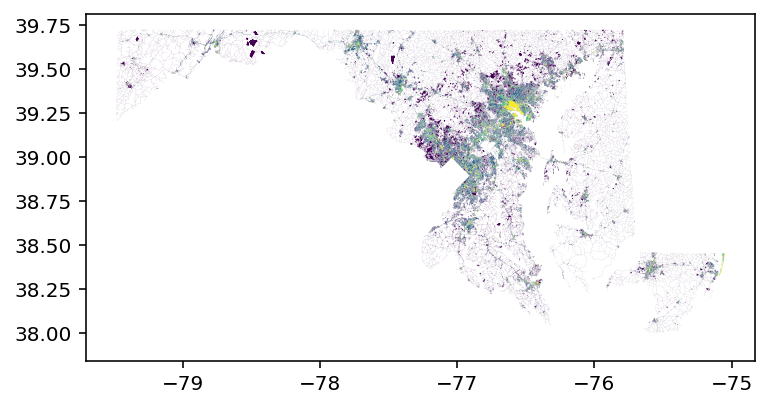

In [206]:
nl.plot('value')

In [3]:
from tobler.util import get_gadm

In [5]:
usa = get_gadm('usa', 2)

/Users/knaaptime/anaconda3/envs/geosnap/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [11]:
la = usa[usa.NAME_2.str.lower().str.contains('los angeles')]

In [ ]:
usa.plot()

In [210]:
import tobler

In [211]:
tobler.util.get_gadm?

Object `tobler.util.get_gadm` not found.


In [15]:
la_urban = extract_raster_features(la, nlcd_path, pixel_types=[21,22,23,24])

<AxesSubplot:>

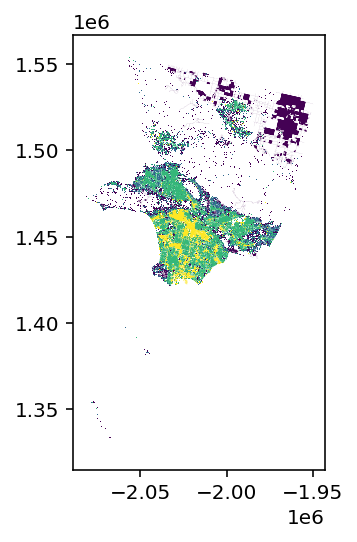

In [17]:
la_urban.plot('value')